In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/sentiment_analysis'

/content/drive/MyDrive/sentiment_analysis


# **Loading Data**

In [ ]:
import pandas as pd

In [ ]:
dataset_path = "hate.csv"
df = pd.read_csv(dataset_path,encoding='cp437')
# Display the first few rows of the dataset
df.head(10)

,Unnamed: 0,comment,label
0,1,dalits are lowlives,N
1,2,gay people are a burden to our society,N
2,3,Arabs are not welcome,N
3,4,I'm not saying we should actually eliminate he...,N
4,5,bananas are for black people,N
5,6,asian people are the shit,P
6,7,women can not reproduce kids but men can in al...,N
7,8,i N wearing black in the summer!,P
8,9,Who cares what Chinese people think?,N
9,10,i try to punch a letter box when i see one,N


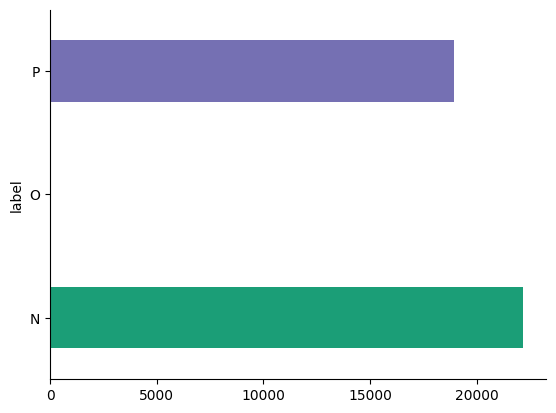

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df['label'].value_counts()

N    22158
P    18950
O       36
Name: label, dtype: int64

# **Data Preprocessing**

In [ ]:
df = df[['comment', 'label']][df['label'] != 'O'].reset_index(drop=True)
df.head(2)

,comment,label
0,dalits are lowlives,N
1,gay people are a burden to our society,N


In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

# Download NLTK resources (one-time step)
nltk.download('punkt')
nltk.download('stopwords')

# Define stopwords and punctuation
stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)

# Function to preprocess text
def preprocess_text(text):
    text = str(text)
    # Lowercase the text
    text = text.lower()
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords and punctuation
    tokens = [token for token in tokens if token not in stop_words and token not in punctuations]
    # Reconstruct the text
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

# Apply preprocessing to the dataset
df['preprocessed_text'] = df['comment'].apply(preprocess_text)

# Display the preprocessed dataset


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df.head()

,comment,label,preprocessed_text
0,dalits are lowlives,N,dalits lowlives
1,gay people are a burden to our society,N,gay people burden society
2,Arabs are not welcome,N,arabs welcome
3,I'm not saying we should actually eliminate he...,N,'m saying actually eliminate heebs .. wish nat...
4,bananas are for black people,N,bananas black people


In [ ]:
# prompt: label encoder for label column

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

df['label'] = le.fit_transform(df['label'])

In [ ]:
df.head()

,comment,label,preprocessed_text
0,dalits are lowlives,0,dalits lowlives
1,gay people are a burden to our society,0,gay people burden society
2,Arabs are not welcome,0,arabs welcome
3,I'm not saying we should actually eliminate he...,0,'m saying actually eliminate heebs .. wish nat...
4,bananas are for black people,0,bananas black people


# **Data Splitting and Tokenization**

In [ ]:
from sklearn.model_selection import train_test_split
import torch
from tqdm import tqdm
X=df['preprocessed_text']

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [ ]:
#Tokenize and encode the data using the BERT tokenizer
from transformers import BertTokenizer, BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
max_len= 128
# Tokenize and encode the sentences
X_train_encoded = tokenizer.batch_encode_plus(X_train.tolist(),
											padding=True,
											truncation=True,
											max_length = max_len,
											return_tensors='tf')

X_val_encoded = tokenizer.batch_encode_plus(X_val.tolist(),
											padding=True,
											truncation=True,
											max_length = max_len,
											return_tensors='tf')
X_test_encoded = tokenizer.batch_encode_plus(X_test.tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')


# **Create Model and Train**

In [ ]:
from transformers import TFBertForSequenceClassification
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Compile the model with an appropriate optimizer, loss function, and metrics
import tensorflow as tf
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
# Step 5: Train the model
history = model.fit(
    [X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
    y_train,
    validation_data=(
      [X_val_encoded['input_ids'], X_val_encoded['token_type_ids'], X_val_encoded['attention_mask']],y_val),
    batch_size=32,
    epochs=5
)

Epoch 1/5
771/771 [==============================] - 768s 933ms/step - loss: 0.5507 - accuracy: 0.7026 - val_loss: 0.4698 - val_accuracy: 0.7645
Epoch 2/5
771/771 [==============================] - 717s 930ms/step - loss: 0.4195 - accuracy: 0.7951 - val_loss: 0.4540 - val_accuracy: 0.7732
Epoch 3/5
771/771 [==============================] - 716s 929ms/step - loss: 0.3283 - accuracy: 0.8427 - val_loss: 0.4946 - val_accuracy: 0.7619
Epoch 4/5
771/771 [==============================] - 717s 930ms/step - loss: 0.2390 - accuracy: 0.8898 - val_loss: 0.5378 - val_accuracy: 0.7537
Epoch 5/5
771/771 [==============================] - 705s 915ms/step - loss: 0.1753 - accuracy: 0.9247 - val_loss: 0.6588 - val_accuracy: 0.7515


# **Evaluation and Saving the Model**

In [ ]:
test_loss, test_accuracy = model.evaluate(
    [X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']],
    y_test
)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

257/257 [==============================] - 71s 276ms/step - loss: 0.7023 - accuracy: 0.7440
Test loss: 0.7023028135299683, Test accuracy: 0.7439795732498169


In [ ]:

path = '/content/drive/MyDrive/sentiment_analysis'
# Save tokenizer
tokenizer.save_pretrained(path +'/Tokenizer')

# Save model
model.save_pretrained(path +'/Model')

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained(path +'/Tokenizer')

# Load model
bert_model = TFBertForSequenceClassification.from_pretrained(path +'/Model')

Some layers from the model checkpoint at /content/drive/MyDrive/sentiment_analysis/Model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/sentiment_analysis/Model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
pred = bert_model.predict(
	[X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']])

# pred is of type TFSequenceClassifierOutput
logits = pred.logits

# Use argmax along the appropriate axis to get the predicted labels
pred_labels = tf.argmax(logits, axis=1)

# Convert the predicted labels to a NumPy array
pred_labels = pred_labels.numpy()

label = {
	1: 'positive',
	0: 'Negative'
}

# Map the predicted labels to their corresponding strings using the label dictionary
pred_labels = [label[i] for i in pred_labels]
Actual = [label[i] for i in y_test]

print('Predicted Label :', pred_labels[:10])
print('Actual Label :', Actual[:10])


257/257 [==============================] - 77s 282ms/step
Predicted Label : ['Negative', 'positive', 'Negative', 'positive', 'Negative', 'Negative', 'positive', 'Negative', 'Negative', 'positive']
Actual Label : ['Negative', 'positive', 'Negative', 'positive', 'Negative', 'Negative', 'positive', 'Negative', 'Negative', 'Negative']


In [ ]:
from sklearn.metrics import classification_report
print("Classification Report: \n", classification_report(Actual, pred_labels))


Classification Report: 
               precision    recall  f1-score   support

    Negative       0.78      0.73      0.76      4459
    positive       0.71      0.76      0.73      3763

    accuracy                           0.74      8222
   macro avg       0.74      0.75      0.74      8222
weighted avg       0.75      0.74      0.74      8222



In [ ]:
def Get_sentiment(Review, Tokenizer=bert_tokenizer, Model=bert_model):
	# Convert Review to a list if it's not already a list
	if not isinstance(Review, list):
		Review = [Review]

	Input_ids, Token_type_ids, Attention_mask = Tokenizer.batch_encode_plus(Review,
																			padding=True,
																			truncation=True,
																			max_length=128,
																			return_tensors='tf').values()
	prediction = Model.predict([Input_ids, Token_type_ids, Attention_mask])

	# Use argmax along the appropriate axis to get the predicted labels
	pred_labels = tf.argmax(prediction.logits, axis=1)

	# Convert the TensorFlow tensor to a NumPy array and then to a list to get the predicted sentiment labels
	pred_labels = [label[i] for i in pred_labels.numpy().tolist()]
	return pred_labels


In [ ]:
Review ='''i N wearing black in the summer!'''
Review = preprocess_text(Review)
print(Review)
Get_sentiment(Review)

n wearing black summer
1/1 [==============================] - 0s 105ms/step


['positive']